In [61]:
import torch
from torch import nn
import numpy as np
import torchvision
import torchvision.transforms as transforms
import my_utils as mu



In [62]:
##DataLoader Code:
# Define the data transformations to be applied
#ToTensor() converts the input PIL image to a PyTorch tensor.
#transforms.Normalize normalizes the tensor image with a mean and standard deviation.
transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load the CIFAR-10 training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# Create a DataLoader for the training dataset
train_iter = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=4)

# Load the CIFAR-10 test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# Create a DataLoader for the test dataset
test_iter = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=4)

# Define the classes in the CIFAR-10 dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [63]:
#Checking size of data and watnot
X, y = next(iter(train_iter)) # first batch
print(X.size())
print(y.size())
##Ok all makes sense

torch.Size([256, 3, 32, 32])
torch.Size([256])


In [64]:
#Defining MLP 
class MLP(torch.nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs):
        super(MLP, self).__init__()
        self.num_inputs = num_inputs
        self.num_hidden = num_hidden
        self.num_outputs = num_outputs
        self.Linear1 = nn.Linear(num_inputs, num_hidden)
        self.Linear2 = nn.Linear(num_hidden, num_outputs)
        #Init weights
        torch.nn.init.normal_(self.Linear1.weight, std=0.01) #init the weights
        torch.nn.init.zeros_(self.Linear1.bias) #init the bias
        torch.nn.init.normal_(self.Linear2.weight, std=0.01) #init the weights
        torch.nn.init.zeros_(self.Linear2.bias) #init the bias
        
        
        self.relu = nn.ReLU()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # 1x1 average pooling layer
        self.Fltn = nn.Flatten()
        
        
    def forward(self, x):
        out = self.avgpool(x)
        out = self.Fltn(out)
        #out = out.view(-1, out.numel())
        #out = out.view(-1,self.num_inputs)
        
        out = self.Linear1(out)
        out = self.relu(out)
        out = self.Linear2(out)
        out = self.relu(out)

        return out
    

In [65]:
#Testing
# Example usage
input_dim = 3 
hidden_dim = 24
output_dim = 4 
model = MLP(input_dim, hidden_dim, output_dim)

In [66]:
print(X.size())
MLP_out = model(X)
MLP_out
MLP_out.size()
#print(MLP_out[0][3])

torch.Size([256, 3, 32, 32])


torch.Size([256, 4])

In [67]:
##Now I need 4 convolutional layers
class Block(torch.nn.Module):
  def __init__(self,num_inputs,num_outputs):
        super(Block, self).__init__()
        #define 4 convolutions
        self.conv1 = nn.Conv2d(in_channels=num_inputs, out_channels=num_outputs, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=num_inputs, out_channels=num_outputs, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(in_channels=num_inputs, out_channels=num_outputs, kernel_size=7, stride=1, padding=3)
        self.conv4 = nn.Conv2d(in_channels=num_inputs, out_channels=num_outputs, kernel_size=9, stride=1, padding=4)
        self.Sigmoid = nn.Sigmoid()
        self.Avg = nn.AvgPool2d(2, stride=2, padding=0)
        self.MLP = MLP(num_inputs,24,4)
        self.Fltn = nn.Flatten()
  def forward(self, x):

        MLP_out = self.MLP(x)
        MLP_out = MLP_out.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)  # Size: [batch_size, 4, 1, 1, 1]
        out1 = self.conv1(x)*MLP_out[:,0]
        out2 = self.conv2(x)*MLP_out[:,1]
        out3 = self.conv3(x)*MLP_out[:,2]
        out4 = self.conv4(x)*MLP_out[:,3]
        
        #to multiply we have to change the dimensions of MLP output:
        #out1 = self.Fltn(out1)
        #out2 = self.Fltn(out2)
        #out3 = self.Fltn(out3)
        #out4 = self.Fltn(out4)
        
        out1 = self.Sigmoid(out1)
        out1 = self.Avg(out1)

        out2 = self.Sigmoid(out2)
        out2 = self.Avg(out2)

        out3 = self.Sigmoid(out3)
        out3 = self.Avg(out3)

        out4 = self.Sigmoid(out4)
        out4 = self.Avg(out4)
            
        
        out = out1 + out2 + out3 +out4
         
       
        return out

In [68]:
#FredNet:
class FredNet(torch.nn.Module):
  def __init__(self):
        super(FredNet, self).__init__()

        #define blocks
        self.block1 = Block(3,12)
        self.block2 = Block(12,48)
        self.block3 = Block(48,192)
        self.Linear1 = nn.Linear(3072, 10)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.Fltn = nn.Flatten()
        #Must add final classifier                
        
  def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        out = self.block3(out)
        out = self.avgpool(out)
        out = self.Fltn(x)
        out = self.Linear1(out)
        
        return out


In [69]:
net = FredNet()
#loss function(must tweak)
myloss = nn.CrossEntropyLoss()
#optimizer (must tweak)
optimizer = torch.optim.Adam(net.parameters(), lr=0.1)

In [70]:
def accuracy(y_hat, y):  #y_hat is a matrix; 2nd dimension stores prediction scores for each class.
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1) # Predicted class is the index of max score         
    cmp = (y_hat.type(y.dtype) == y)  # because`==` is sensitive to data types
    return float(torch.sum(cmp)) # Taking the sum yields the number of correct predictions.

# Example: only 1 sample is correctly classified.
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
accuracy(y_hat, y) / len(y)

0.5

In [71]:
class Accumulator:  
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n # [0, 0, ..., 0]
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

In [72]:
def evaluate_accuracy(net, data_iter): 
    """Compute the accuracy for a model on a dataset."""
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions
    for _, (X, y) in enumerate(data_iter):
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [73]:
def train_epoch_ch3(net, train_iter, loss, optimizer):  
    """The training function for one epoch."""
    # Set the model to training mode
    if isinstance(net, torch.nn.Module):
        net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        metric.add(float(l) * len(y), accuracy(y_hat, y), y.size().numel())
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

In [74]:
class Animator:  
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        mu.use_svg_display()
        self.fig, self.axes = mu.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: mu.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [75]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, optimizer):  
    """Train a model."""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, optimizer)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

TypeError: 'Tensor' object is not callable

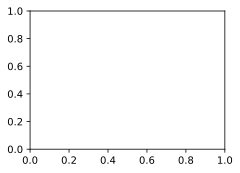

In [76]:
num_epochs = 10
train_ch3(net, train_iter,test_iter,loss,num_epochs,optimizer)